<a href="https://colab.research.google.com/github/pauljhp/Auto_Stockselection/blob/main/MSCI_China_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import sys, os
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive')

Mounted at /content/drive


## 1. Load in data & EDA

In [ ]:
# load in df
df = pd.read_csv('/content/drive/MyDrive/stockClassification/MXCN.csv', header=0, index_col=[0,1,2,3])

# set index name
df.index.set_names(names=['ticker', 'start_date','ticker','start_date'], inplace=True)

# reset index
df.reset_index(level=[2,3], inplace=True)

In [ ]:
df.drop(['H_category', 'H_activeReturn', 'H_IR', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category',  # drop target variables 
         'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg', 'd&a_to_sales_std',
         'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
         'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
         'best_pe_ratio_std', 
         ], # drop variables with too few obervations; not worth imputating
            axis='columns').iloc[:,50:].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5462 entries, ('700 HK equity', '2015-03-30', '700 HK equity', '2015-03-30') to ('002572 C2 equity', '2018-06-30', '002572 C2 equity', '2018-06-30')
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   accounts_payable_turnover_days_std  3619 non-null   float64
 1   cash_conversion_cycle_std           3522 non-null   float64
 2   fixed_charge_coverage_ratio_std     1250 non-null   float64
 3   interest_coverage_ratio_std         1303 non-null   float64
 4   asset_to_eqy_std                    4379 non-null   float64
 5   net_debt_to_shrhldr_eqty_std        4379 non-null   float64
 6   tot_debt_to_tot_eqy_std             4379 non-null   float64
 7   operating_roic_avg                  4339 non-null   float64
 8   normalized_roe_avg                  4339 non-null   float64
 9   oper_roe_avg                        4351 non-nul

In [ ]:
df.describe()

,H_activeReturn,H_avgactiveReturn,H_activeRisk,H_IR,H_avgIR,T_activeReturn,T_avgactiveReturn,T_activeRisk,T_IR,T_avgIR,cash_%_current_market_cap_cur,px_to_cash_flow_cur,px_to_sales_ratio_cur,eqy_dvd_yld_ind_cur,px_to_tang_bv_per_sh_cur,market_capitalization_to_bv_cur,sales_growth_avg,sales_5yr_avg_gr_avg,free_cash_flow_5_year_growth_avg,ebitda_growth_avg,gross_margin_avg,ebitda_margin_avg,ebit_margin_avg,rd_expend_to_net_sales_avg,d&a_to_sales_avg,T12_sg&a_expn_%_t12_sales_avg,eps_growth_avg,eff_tax_rate_avg,sales_growth_std,sales_5yr_avg_gr_std,free_cash_flow_5_year_growth_std,ebitda_growth_std,gross_margin_std,ebitda_margin_std,ebit_margin_std,rd_expend_to_net_sales_std,d&a_to_sales_std,T12_sg&a_expn_%_t12_sales_std,eps_growth_std,eff_tax_rate_std,...,invent_days_std,accounts_payable_turnover_days_std,cash_conversion_cycle_std,fixed_charge_coverage_ratio_std,interest_coverage_ratio_std,asset_to_eqy_std,net_debt_to_shrhldr_eqty_std,tot_debt_to_tot_eqy_std,operating_roic_avg,normalized_roe_avg,oper_roe_avg,return_on_asset_avg,asset_turnover_avg,operating_roic_std,normalized_roe_std,oper_roe_std,return_on_asset_std,asset_turnover_std,historical_market_cap_avg,sales_rev_turn_avg,total_equity_avg,historical_market_cap_std,sales_rev_turn_std,total_equity_std,cash_%_current_market_cap_avg,px_to_cash_flow_avg,best_pe_ratio_avg,px_to_sales_ratio_avg,eqy_dvd_yld_ind_avg,px_to_tang_bv_per_sh_avg,market_capitalization_to_bv_avg,cash_%_current_market_cap_std,px_to_cash_flow_std,best_pe_ratio_std,px_to_sales_ratio_std,eqy_dvd_yld_ind_std,px_to_tang_bv_per_sh_std,market_capitalization_to_bv_std,best_pe_ratio_cur,best_cur_ev_to_ebitda_cur
count,4170.000000,4383.000000,4383.000000,4170.000000,4383.000000,4899.000000,5043.000000,5043.000000,4899.000000,5043.000000,5332.000000,1413.000000,1892.000000,4707.000000,1814.000000,1896.000000,4406.000000,3783.000000,1849.000000,238.000000,3753.000000,217.000000,3735.000000,1637.000000,289.000000,3721.000000,4390.000000,4382.000000,4380.000000,3691.000000,1455.000000,221.000000,3726.000000,212.000000,3721.000000,1304.000000,257.000000,3707.000000,4354.000000,4345.000000,...,3559.000000,3619.000000,3522.000000,1250.000000,1303.000000,4379.000000,4379.000000,4379.000000,4339.000000,4339.000000,4351.000000,4339.000000,4339.000000,4319.000000,4316.000000,4320.000000,4318.000000,4319.000000,9.340000e+02,4482.000000,4.402000e+03,913.000000,4456.000000,4379.000000,4436.000000,637.000000,7.000000,902.000000,5103.000000,917.000000,959.000000,4418.000000,627.000000,5.000000,895.000000,5060.000000,907.000000,949.000000,8.000000,5.000000
mean,0.115183,0.162034,0.155939,0.708230,0.754721,0.022792,0.040711,0.132581,-0.173153,-0.213554,31.849466,17.138597,8.147869,1.977205,3.817956,1.110596,110.809991,922.310551,27.857363,5.375094,32.036273,15.878187,12.195189,3.542929,7.731157,17.646877,113.368787,23.456738,203.527610,2196.466873,31.463118,92.577078,4.926777,4.235590,4.064556,1.705555,2.083436,2.355652,363.751372,14.738253,...,46.075915,16.488403,52.467976,203.173598,271.054392,0.336549,23.721433,19.593503,9.236152,12.871166,16.532432,5.962737,0.666406,3.479119,4.458401,5.798239,1.947377,0.127527,1.349274e+05,19630.454532,6.199362e+04,32542.940708,3750.133799,7189.593733,31.879313,17.834572,7.494786,3.208350,1.985076,4.528306,2.995045,9.761973,14.588141,1.163834,0.912194,0.623375,3.396973,0.843960,6.999000,8.375600
std,0.186733,0.287379,0.163959,1.630638,1.851740,0.192909,0.253409,0.124631,1.936088,2.183042,49.299882,77.468228,66.120235,1.801816,19.999692,36.413055,1436.023739,14928.140081,42.786801,292.275010,18.992519,15.994822,15.253316,6.422653,6.087738,15.798239,751.879314,30.395260,2712.032977,37128.613022,35.808477,206.846405,4.847320,8.410710,10.120950,3.910651,2.310327,6.958321,1944.977122,78.670835,...,357.721655,20.927898,357.718051,3661.610070,3655.234891,0.415128,26.895729,22.973749,9.574607,9.207397,12.806425,5.904888,0.634828,10.328778,8.203449,12.383483,3.565706,0.770520,2.669240e+05,60070.733386,1.

In [ ]:
# check distribution of active return, active risk
def viz_hist(df, fields, title, figsize=(10,10), bins=30):
    data = {field: df[field] for field in fields}
    f, ax = plt.subplots(figsize=figsize)
    for f, d in data.items():
        ax = plt.hist(x=d, bins=bins, alpha=0.7, density=True)
    plt.legend(list(data.keys()))
    plt.title(title)
    plt.show()
 

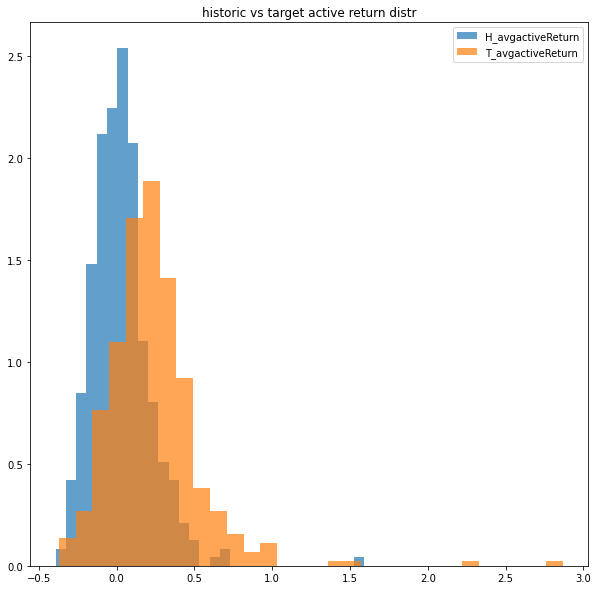

In [ ]:
viz_hist(df.query("start_date=='2015-03-30'"), 
         ['H_avgactiveReturn', 'T_avgactiveReturn'], 
         title='historic vs target active return distr')

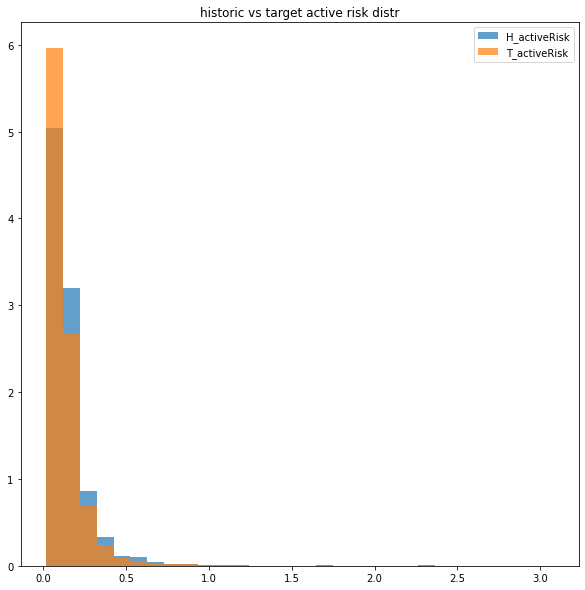

In [ ]:
viz_hist(df, ['H_activeRisk', 'T_activeRisk'], title='historic vs target active risk distr')

In [ ]:
df.index.get_level_values(1).unique()

Index(['2015-03-30', '2015-06-30', '2015-09-30', '2015-12-30', '2016-03-30',
       '2016-06-30', '2016-09-30', '2016-12-30', '2017-03-30', '2017-06-30',
       '2017-09-30', '2017-12-30', '2018-03-30', '2018-06-30'],
      dtype='object', name='start_date')

In [ ]:
pd.qcut(df.query("start_date=='2015-03-30'").T_avgactiveReturn, q=10, labels=list(range(0,10)))

ticker            start_date
700 HK equity     2015-03-30      5
JD UW equity      2015-03-30    NaN
939 HK equity     2015-03-30      2
BIDU UW equity    2015-03-30      2
2318 HK equity    2015-03-30      3
                               ... 
000961 C2 equity  2015-03-30      8
002075 C2 equity  2015-03-30      9
600340 C1 equity  2015-03-30      7
001914 C2 equity  2015-03-30      6
002572 C2 equity  2015-03-30      9
Name: T_avgactiveReturn, Length: 448, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [ ]:
def getCat(df, field, newfieldname, bins=10, inplace=False):
    '''generates target field category
    Parameters
    ----
    inplace: if True returns None, appends new field inplace
    '''
    slices = {}
    newflds = {}
    for date in df.index.get_level_values(1).unique(): # FIXME - clean up for more general use case
        slices[date] = df.query('start_date==@date')
        newflds[date] = pd.qcut(slices[date][field], q=bins, labels=[int(i*bins) for i in range(0, bins)])
        slices[date].loc[:,newfieldname] = newflds[date]

    if inplace:
        pass
        # df[newfieldname] = pd.cut(df[field], bins=bins, labels=[int(i*bins) for i in range(0, bins)])
    else:
        # newfield = pd.cut(df[field], bins=bins, labels=[int(i*bins) for i in range(0, bins)])
        # newfield.name = newfieldname
        return pd.concat(slices.values()) #newfield

In [ ]:
# add target risk & return category
df.drop(['H_category', 'T_category'], axis='columns', inplace=True)
df = getCat(df, 'T_avgactiveReturn', 'T_returnCat', inplace=False)
df = getCat(df, 'T_activeRisk', 'T_riskCat', inplace=False)
df = getCat(df, 'H_avgactiveReturn', 'H_returnCat', inplace=False)
df

In [ ]:
df.T_returnCat.unique()

[50, NaN, 20, 30, 0, ..., 70, 10, 40, 80, 60]
Length: 11
Categories (10, int64): [0 < 10 < 20 < 30 ... 60 < 70 < 80 < 90]

In [ ]:
ls = []
for i, row in df.iterrows():
    if row.T_avgactiveReturn > 0.05:
        x = 2
    elif 0 < row.T_avgactiveReturn <= 0.05:
        x = 1
    elif -0.05 < row.T_avgactiveReturn <= 0:
        x = -1
    elif row.T_avgactiveReturn <= -0.05:
        x = -2
    else:
        x = ''
    
    if row.T_avgIR > 2:
        y = 2
    elif 1 < row.T_avgIR <= 2:
        y = 1
    elif 0 < row.T_avgIR < 1:
        y = - 1
    elif row.T_avgIR <= 0:
        y = -2
    else:
        y = ''

    ls.append(f"({x}, {y})")

H_ls = []
for i, row in df.iterrows():
    if row.H_avgactiveReturn > 0.05:
        x = 2
    elif 0 < row.H_avgactiveReturn <= 0.05:
        x = 1
    elif -0.05 < row.H_avgactiveReturn <= 0:
        x = -1
    elif row.H_avgactiveReturn <= -0.05:
        x = -2
    else:
        x = ''
    
    if row.H_avgIR > 2:
        y = 2
    elif 1 < row.H_avgIR <= 2:
        y = 1
    elif 0 < row.H_avgIR < 1:
        y = - 1
    elif row.H_avgIR <= 0:
        y = -2
    else:
        y = ''

    H_ls.append(f"({x}, {y})")

In [ ]:
df.T_category = ls
df.H_category = H_ls

In [ ]:
df = df[(~df.T_returnCat.isna()) & (~df.T_riskCat.isna())] # drop not categorized target

In [ ]:
df.shape

(5043, 111)

# 2. Data cleaning


## 2.1. Transoforming categorical data into numerical

In [ ]:
# uncomment to transform categorical value
# le = preprocessing.LabelEncoder()
# H_cat_encoded = le.fit_transform(df.H_returnCat)
# # H_cat_encoded

# T_cat_encoded = le.fit_transform(df.T_returnCat)
# print(np.unique(T_cat_encoded))
# df.T_returnCat = T_cat_encoded
# df.H_returnCat = H_cat_encoded
# # test_T_cat_encoded = le.fit_transform()

In [ ]:
df.shape

(5043, 108)

In [ ]:
df.T_returnCat.unique()

[50, NaN, 20, 30, 0, ..., 70, 10, 40, 80, 60]
Length: 11
Categories (10, int64): [0 < 10 < 20 < 30 ... 60 < 70 < 80 < 90]

In [ ]:
# target variable distribution
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.kdeplot(H_cat_encoded, alpha=0.7)
ax = sns.kdeplot(T_cat_encoded, alpha=0.5)
plt.xticks(rotation=90)
plt.legend(['historical', 'target'])
plt.xticks(ticks = np.unique(H_cat_encoded), labels = le.inverse_transform(np.unique(H_cat_encoded)),rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


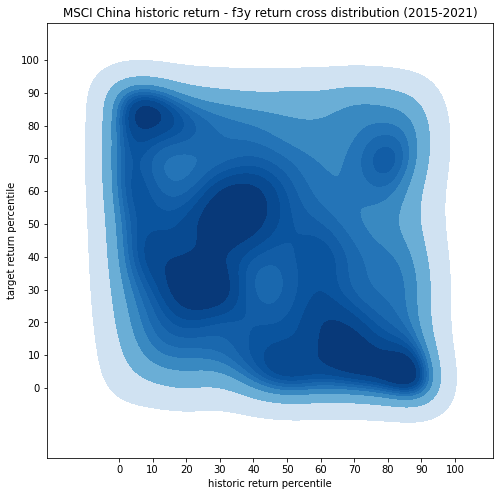

In [ ]:
# Hist cat vs Target cat
f, ax = plt.subplots(figsize=(8,8))
ax = sns.kdeplot(df.H_returnCat.astype(float), df.T_returnCat.astype(float), cmap='Blues', shade=True)
plt.xlabel('historic return percentile')
plt.ylabel('target return percentile')
plt.xticks([i*10 for i in range(11)])
plt.yticks([i*10 for i in range(11)])
plt.title('MSCI China historic return - f3y return cross distribution (2015-2021)')
plt.show()

In [ ]:
# Hist cat vs Target cat
f, ax = plt.subplots(figsize=(8,8))
ax = sns.kdeplot(H_cat_encoded, T_cat_encoded, cmap='Blues', shade=True)
plt.xlabel('historic category')
plt.ylabel('target category')
plt.xticks(ticks = np.unique(H_cat_encoded), labels = le.inverse_transform(np.unique(H_cat_encoded)),rotation=90)
plt.yticks(ticks = np.unique(T_cat_encoded), labels = le.inverse_transform(np.unique(T_cat_encoded)))
plt.title('historic return/risk vs f3y realized return/risk')
plt.text(-10, -10, 'Note - (active return, active risk) - 2 means >5% active return/>2 IR;')
# plt.yticks(le.inverse_transform(np.unique(T_cat_encoded)),rotation=90)
plt.show()

In [ ]:
df.columns

Index(['ticker', 'start_date', 'H_activeReturn', 'H_avgactiveReturn',
       'H_activeRisk', 'H_IR', 'H_avgIR', 'T_activeReturn',
       'T_avgactiveReturn', 'T_activeRisk',
       ...
       'best_pe_ratio_std', 'px_to_sales_ratio_std', 'eqy_dvd_yld_ind_std',
       'px_to_tang_bv_per_sh_std', 'market_capitalization_to_bv_std',
       'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur', 'T_returnCat',
       'T_riskCat', 'H_returnCat'],
      dtype='object', length=111)

In [ ]:
# amputating missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit_transform(df.drop(['T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_returnCat', 'T_riskCat', 'H_returnCat', 'start_date', 'ticker'], axis='columns')) #.fillna(0))

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


array([[ 3.93233101e-01,  3.72489250e-01,  7.73357698e-02, ...,
         1.47590500e+00, -1.02262847e+02, -1.76027390e+00],
       [ 2.56594306e-01,  4.62374648e-02,  9.70020245e-02, ...,
         5.52386498e-01, -2.49002826e+02,  1.04841040e+01],
       [ 1.33902779e-02,  1.18955563e-02,  1.68926738e-02, ...,
         1.34744508e-01,  4.43351699e+03,  1.08425140e+02],
       ...,
       [ 1.47067828e-01,  5.08190233e-01,  3.13491513e-01, ...,
         4.92423120e-01, -1.73025708e+02,  2.76955146e+00],
       [ 1.14030728e-01,  4.00387114e-01,  2.20067660e-01, ...,
         1.40847544e+00, -1.36338303e+01,  5.95784260e+00],
       [ 3.11549641e-01,  6.47560095e-01,  2.04164104e-01, ...,
         7.80902437e-01, -2.25427717e+02,  4.87868563e+00]])

In [ ]:
# balancing data set 

# 3. Train the model


In [ ]:
# df.H_category = H_cat_encoded
# df.T_category = T_cat_encoded
# df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5043 entries, ('700 HK equity', '2015-03-30', '700 HK equity', '2015-03-30') to ('002572 C2 equity', '2018-06-30', '002572 C2 equity', '2018-06-30')
Columns: 108 entries, H_activeReturn to best_cur_ev_to_ebitda_cur
dtypes: float64(106), int64(2)
memory usage: 4.2+ MB


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
# PCA
from sklearn.decomposition import PCA
imp = IterativeImputer(max_iter=10, random_state=0)
X = df.drop(['H_returnCat', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_returnCat',  # drop target variables 
            'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
            'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
            'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
            'best_pe_ratio_std', 'start_date', 'ticker', 'T_riskCat'
         ], # drop variables with too few obervations; not worth imputating
            axis='columns')
X.replace(float('inf'), 99999999).replace(float('-inf'), -99999999)
X.reindex(sorted(X.columns), axis='columns') # ordering features to make sure inference data is of the same order
X_imp = imp.fit_transform(X) # imputate X
# pca = PCA(n_components=5)
# principalComponents = pca.fit_transform(X)
# principalDF = pd.DataFrame(data = principalComponents
            #  , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
sorted(df.drop(['H_category', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category'], axis='columns').fillna(-1).columns)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [ ]:
{cat: sum(df.T_category==cat) for cat in df.T_category.unique()}

{0: 460, 1: 2091, 2: 389, 3: 9, 4: 631, 5: 809, 6: 654}

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X),
                #  index=pd.MultiIndex.from_tuples([(t,d) for t,d in zip(X.index.get_level_values(0), X.index.get_level_values(1))]))
X_imp = pd.DataFrame(scaler.fit_transform(X_imp),
                 index=pd.MultiIndex.from_tuples([(t,d) for t,d in zip(X.index.get_level_values(0), X.index.get_level_values(1))]))
X_train, X_test, y_train, y_test = train_test_split(X_imp, df.T_returnCat, test_size=0.3)
# X_train, X_test, y_train_risk, y_test_risk = train_test_split(X_imp, df.T_riskCat, test_size=0.3)

smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
# X_train_smt, y_train_smt_risk = smt.fit_resample(X_train, y_train_risk)

In [ ]:
y_train_risk

In [ ]:
{i:sum(y_train==i) for i in y_train.unique()}

{0: 366,
 10: 357,
 20: 347,
 30: 362,
 40: 344,
 50: 351,
 60: 359,
 70: 346,
 80: 343,
 90: 355}

In [ ]:
{i:sum(y_train_smt==i) for i in np.unique(y_train_smt)}

{0: 366,
 10: 366,
 20: 366,
 30: 366,
 40: 366,
 50: 366,
 60: 366,
 70: 366,
 80: 366,
 90: 366}

In [ ]:
# kNN classifier w/ k=5 - using SMOTE balanced data
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train_smt, y_train_smt)

#Predict the response for test dataset
y_pred = knn.predict(X_test)
print("accuracy = ", metrics.accuracy_score(y_test, y_pred))

accuracy =  0.3053536021150033


In [ ]:
# kNN classifier w/ k=5 - not using SMOTE balanced data

knn2 = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred2 = knn2.predict(X_test)
print("accuracy = ", metrics.accuracy_score(y_test, y_pred2))

accuracy =  0.29345670852610706


In [ ]:
# kNN classifier w/ k=3 - not using SMOTE balanced data - for riskCat

knn2_risk = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
knn2_risk.fit(X_train, y_train_risk)

#Predict the response for test dataset
y_pred2_risk = knn2_risk.predict(X_test)
print("accuracy = ", metrics.accuracy_score(y_test_risk, y_pred2_risk))

accuracy =  0.3225380039656312


In [ ]:
y_pred

array([14, 13,  4, ..., 15,  1, 14])

In [ ]:
f, ax = plt.subplots(figsize=(8,8))
ax = sns.kdeplot(y_test, y_pred, cmap='Blues', shade=True)
plt.xlabel('ytest')
plt.ylabel('ypred')
plt.xticks(ticks = np.unique(y_test), labels = le.inverse_transform(np.unique(y_test)),rotation=90)
plt.yticks(ticks = np.unique(y_pred), labels = le.inverse_transform(np.unique(y_pred)))
plt.title('historic return/risk vs f3y realized return/risk')
plt.text(-1, -1, 'Note - (active return, active risk) - 2 means >5% active return/>2 IR;')
# plt.yticks(le.inverse_transform(np.unique(T_cat_encoded)),rotation=90)
plt.show()

In [ ]:
from sklearn import metrics
print(f"knn (w/ SMOTE, k=5) accuracy = {metrics.accuracy_score(y_test, y_pred)}")
print(f"knn (w/o SMOTE, k=5) accuracy = {metrics.accuracy_score(y_test, y_pred2)}")

knn (w/ SMOTE, k=5) accuracy = 0.4871116986120291
knn (w/o SMOTE, k=5) accuracy = 0.5221414408460013


In [ ]:
cf_mt.sort_index(axis='index', ascending=True).sort_index(axis='columns', ascending=True)

,90,80,70,60,50,40,30,20,10,0
0,0.032787,0.009009,0.008850,0.008333,0.000000,0.000000,0.024096,0.068323,0.082524,0.409962
10,0.000000,0.000000,0.008850,0.016667,0.008130,0.015385,0.102410,0.149068,0.228155,0.203065
20,0.008197,0.009009,0.017699,0.025000,0.048780,0.076923,0.114458,0.242236,0.218447,0.099617
30,0.000000,0.009009,0.026549,0.016667,0.065041,0.161538,0.168675,0.149068,0.145631,0.099617
40,0.016393,0.036036,0.035398,0.066667,0.170732,0.223077,0.168675,0.142857,0.111650,0.076628
50,0.000000,0.090090,0.044248,0.158333,0.227642,0.161538,0.168675,0.105590,0.063107,0.034483
60,0.024590,0.090090,0.230088,0.233333,0.186992,0.130769,0.102410,0.062112,0.019417,0.022989
70,0.122951,0.108108,0.300885,0.216667,0.162602,0.100000,0.072289,0.024845,0.063107,0.022989
80,0.180328,0.423423,0.194690,0.216667,0.065041,0.069231,0.042169,0.018634,0.043689,0.022989
90,0.614754,0.225225,0.132743,0.041667,0.065041,0.061538,0.036145,0.037267,0.024272,0.007663


In [ ]:
## w/ SMOTE
y_true = y_test.values # le.inverse_transform(y_test.values).astype(str)
y_p = y_pred # le.inverse_transform(y_pred).astype(str)
labels = y_test.unique() #le.inverse_transform(y_test.sort_values(ascending=True).unique()).astype(str)
cf_mt = pd.DataFrame(metrics.confusion_matrix(y_true, y_p, labels=labels, normalize='pred'), columns=labels, index=labels)
cf_mt = cf_mt.sort_index(axis='index', ascending=True).sort_index(axis='columns', ascending=True)
f, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(cf_mt, cmap='Blues', annot=True)
plt.xlabel('actual return percentile')
plt.ylabel('predicted return percentile')
plt.title('MSCI China classification - kNN confusion matrix (% of predictions)')
plt.show()

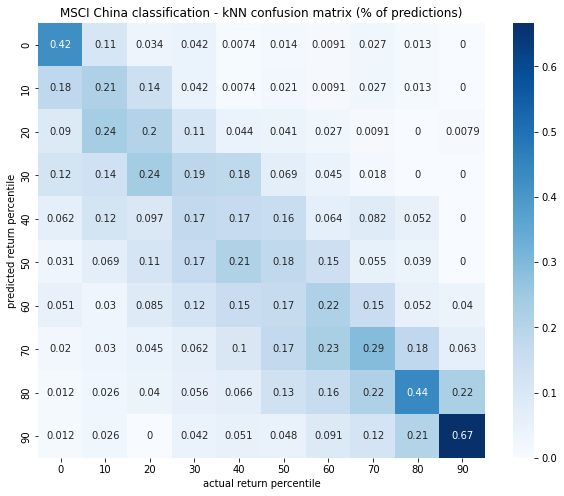

In [ ]:
# w/o SMOTE
y_true = y_test.values # le.inverse_transform(y_test.values).astype(str)
y_p = y_pred2 # le.inverse_transform(y_pred).astype(str)
labels = y_test.unique() #le.inverse_transform(y_test.sort_values(ascending=True).unique()).astype(str)
cf_mt = pd.DataFrame(metrics.confusion_matrix(y_true, y_p, labels=labels, normalize='pred'), columns=labels, index=labels)
cf_mt = cf_mt.sort_index(axis='index', ascending=True).sort_index(axis='columns', ascending=True)
f, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(cf_mt, cmap='Blues', annot=True)
plt.xlabel('actual return percentile')
plt.ylabel('predicted return percentile')
plt.title('MSCI China classification - kNN confusion matrix (% of predictions)')
plt.show()

In [ ]:
 dict(zip(np.unique(y_test),le.inverse_transform(np.unique(y_test))))

In [ ]:
metrics.confusion_matrix(y_true, y_p, labels=labels, normalize=None)

array([[ 25,  84,   6,  14,  12,   3],
       [ 31, 536,  12,  18,  16,  11],
       [ 21,  44,  14,  18,  24,   6],
       [ 19,  99,  13,  31,  31,  13],
       [ 19,  55,  14,  27,  76,  34],
       [ 10,  32,   5,   9,  44,  87]])

In [ ]:
predictions = X_test
predictions['T_category'] = y_pred # le.inverse_transform(y_pred)
predictions_woSMT = X_test
predictions_woSMT['T_category'] = y_pred2 # le.inverse_transform(y_pred2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
recommendations = {}
for d in [f"{y}-{str(m).zfill(2)}-30" for y in range(2015,2019) for m in range(3,15,3) if not (y>=2018 and m>=9)]:
    recommendations[d] = predictions[((predictions.T_category>=80))
                                    & (X_test.index.get_level_values(1)==d)]

In [ ]:
recommendations_woSMT = {}
for d in [f"{y}-{str(m).zfill(2)}-30" for y in range(2015,2019) for m in range(3,15,3) if not (y>=2018 and m>=9)]:
    recommendations_woSMT[d] = predictions_woSMT[((predictions.T_category>=80))
                                    & (X_test.index.get_level_values(1)==d)]

In [ ]:
{k: list(df.index.get_level_values(0)) for k, df in recommendations.items()}

In [ ]:
{k: list(df.index.get_level_values(0)) for k, df in recommendations_woSMT.items()}

In [ ]:
x_pred = pd.read_csv('/content/drive/MyDrive/stockClassification/mxcn_inf2021-10-19.csv', index_col=[0,1,2,3], header=0)
x_pred = x_pred.drop(['H_category'], axis='columns').fillna(0)
# pca = PCA(n_components=5)
# principalComponents = pca.fit_transform(x_pred)
# pcDF_rmd = pd.DataFrame(data = principalComponents
#              , columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

x_pred = x_pred.drop(['best_cur_ev_to_ebitda_avg','best_cur_ev_to_ebitda_std'], 
                     axis='columns').reindex(sorted(df.drop(['H_category', 'T_activeReturn', 
                                                                    'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category'], axis='columns').columns), axis='columns')
check = dict(zip(sorted(df.drop(['H_category', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category'], axis='columns').columns), x_pred.columns))
print(sum([k!=v for k,v in check.items()]))
x_pred = scaler.fit_transform(x_pred)
y_recommendation = knn2.predict(x_pred)

0


In [ ]:
dict(zip(x_pred,X.columns))

In [ ]:
x_pred = pd.read_csv('/content/drive/MyDrive/stockClassification/mxcn_inf2021-10-19.csv', index_col=[0,1,2,3], header=0)
x_pred.index = x_pred.index.get_level_values(0)
knn_rmd_2021_10_19 = x_pred
knn_rmd_2021_10_19['Prediction'] = le.inverse_transform(y_recommendation)


In [ ]:
knn_rmd_2021_10_19[(knn_rmd_2021_10_19.Prediction == '(2, 2)')].index.get_level_values(0)

Index(['600519 C1 equity', '2319 HK equity', 'BILI UW equity',
       '300750 C2 equity', '2688 HK equity', 'TME UN equity', '788 HK equity',
       '1658 HK equity', '601888 C1 equity', '1066 HK equity',
       '2338 HK equity', 'RLX UN equity', '322 HK equity', '002714 C2 equity',
       '780 HK equity', '000333 C2 equity', '600887 C1 equity',
       'IMAB UQ equity', '601816 C1 equity', '000725 C2 equity',
       '2883 HK equity', '600690 C1 equity', '753 HK equity', '493 HK equity',
       '601658 C1 equity', '1787 HK equity', 'BZUN UW equity',
       '2500 HK equity', '2777 HK equity', '300498 C2 equity',
       '600660 C1 equity', '603392 C1 equity', '601600 C1 equity',
       '000100 C2 equity', '300999 C2 equity', '300628 C2 equity',
       '600547 C1 equity', '603290 C1 equity', '603899 C1 equity',
       '601111 C1 equity', '600115 C1 equity', '600885 C1 equity',
       '601021 C1 equity', '601233 C1 equity', '002938 C2 equity',
       '600009 C1 equity', '300003 C2 equity', 

In [ ]:
rmd_2021_10_19.to_csv('/content/drive/MyDrive/stockClassification/2021-10-19 recommendations.csv')

## Decision tree

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [ ]:
clf_pred = clf.predict(X_test)

In [ ]:
print(f"decision tree accuracy = {metrics.accuracy_score(y_test, clf_pred)}")

decision tree accuracy = 0.4573694646397885


## Random Forest

In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
accuracy_smt = {}
accuracy = {}
for n in range(1,150):

    rfc = RandomForestClassifier(n_estimators=n)
    rfc = rfc.fit(X_train_smt, y_train_smt)
    rfc_pred_smt = rfc.predict(X_test)
    accuracy_smt[n] = metrics.accuracy_score(y_test, rfc_pred_smt)
    rfc = rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    accuracy[n] = metrics.accuracy_score(y_test, rfc_pred)

In [ ]:
y_train

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
# X = df.drop(['H_category', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category'], axis='columns')
X = df.drop([
            #  'H_category', 'H_activeReturn', 'H_IR',  'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category',  # drop target variables 
            # 'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
            # 'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
            # 'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
            # 'best_pe_ratio_std', 
             'H_returnCat', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_returnCat',  # drop target variables 
            'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
            'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
            'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
            'best_pe_ratio_std', 'start_date', 'ticker', 'T_riskCat'
         ], # drop variables with too few obervations; not worth imputating
            axis='columns')
X.reindex(sorted(X.columns), axis='columns') # ordering features to make sure inference data is of the same order
X_imp = imp.fit_transform(X) # imputate X

scaler = StandardScaler()
X_imp = pd.DataFrame(scaler.fit_transform(X_imp),
                 index=pd.MultiIndex.from_tuples([(t,d) for t,d in zip(X.index.get_level_values(0), X.index.get_level_values(1))]))
X_train, X_test, y_train, y_test = train_test_split(X_imp, df.T_returnCat, test_size=0.3)

# model balanced by SMOTE
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
feature_names = {i:v for i,v in enumerate(X.columns)}
rfc = RandomForestClassifier(n_estimators=19, min_samples_split=2, criterion='gini', oob_score=False)
rfc = rfc.fit(X_train_smt, y_train_smt)
rfc_pred = rfc.predict(X_test)
print(f"accuracy = {metrics.accuracy_score(y_test, rfc_pred)}")

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecati

accuracy = 0.3456708526107072


In [ ]:
# unbalanced model
rfc_nosmt = RandomForestClassifier(n_estimators=40, min_samples_split=2, criterion='gini', oob_score=False)
rfc_nosmt = rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(f"accuracy w/o SMOTE = {metrics.accuracy_score(y_test, rfc_pred)}")

accuracy w/o SMOTE = 0.6245869134170522


In [ ]:
# save model
from joblib import dump, load
dump(rfc_nosmt, '/content/drive/MyDrive/stockClassification/rfc_nosmot.joblib') 

['/content/drive/MyDrive/stockClassification/rfc_nosmot.joblib']

In [ ]:
rfc_nosmt.score

In [ ]:
len(X.columns)

88

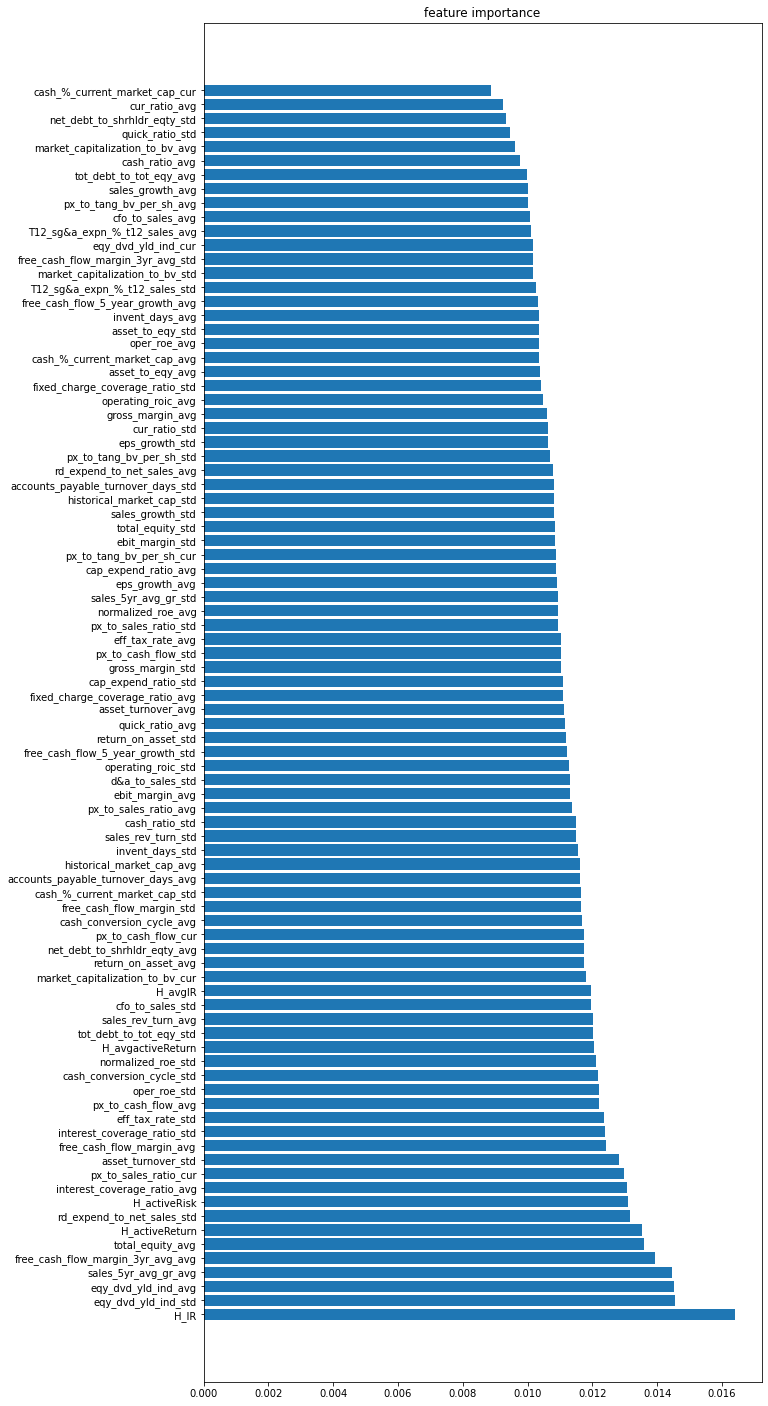

In [ ]:
feature_importance=pd.Series({feature_names[i]: v for i, v in enumerate(rfc.feature_importances_)}).sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10,25))
ax = plt.barh(feature_importance.index, feature_importance)
# plt.xticks(rotation=90)
plt.title('feature importance')
plt.show()

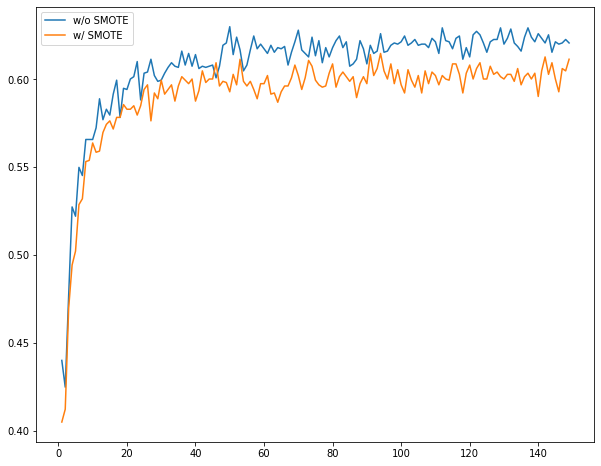

In [ ]:
# plot n_estimate vs accuracy
f, ax = plt.subplots(figsize=(10,8))
ax = plt.plot(list(accuracy.keys()), list(accuracy.values()))
ax = plt.plot(list(accuracy_smt.keys()), list(accuracy_smt.values()))
plt.legend(['w/o SMOTE', 'w/ SMOTE'])
plt.show()

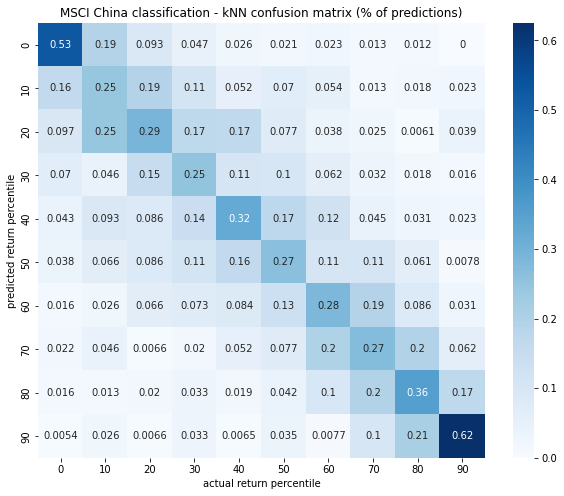

In [ ]:
# confusion matrix

y_true = y_test.values # le.inverse_transform(y_test.values).astype(str)
y_p = rfc_pred # le.inverse_transform(y_pred).astype(str)
labels = y_test.unique() #le.inverse_transform(y_test.sort_values(ascending=True).unique()).astype(str)
cf_mt = pd.DataFrame(metrics.confusion_matrix(y_true, y_p, labels=labels, normalize='pred'), columns=labels, index=labels)
cf_mt = cf_mt.sort_index(axis='index', ascending=True).sort_index(axis='columns', ascending=True)
f, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(cf_mt, cmap='Blues', annot=True)
plt.xlabel('actual return percentile')
plt.ylabel('predicted return percentile')
plt.title('MSCI China classification - RandomForest confusion matrix (% of predictions)')
plt.show()

# y_true = le.inverse_transform(y_test.values).astype(str)
# y_p = le.inverse_transform(rfc_pred).astype(str)
# labels = le.inverse_transform(y_test.sort_values(ascending=True).unique()).astype(str)
# cf_mt = pd.DataFrame(metrics.confusion_matrix(y_true, y_p, labels=labels, normalize='pred'), columns=labels, index=labels).round(2)
# f, ax = plt.subplots(figsize=(10,8))
# ax = sns.heatmap(cf_mt, cmap='Blues', annot=True)
# plt.xlabel('actual')
# plt.ylabel('prediction')
# plt.title('MSCI China classification - confusion matrix w/ random forest (percentage of prediction)\n')
# plt.text(-1, 7, f"accuracy = {metrics.accuracy_score(y_test, rfc_pred):.2f}")
# plt.show()

In [ ]:
x_pred = pd.read_csv('/content/drive/MyDrive/stockClassification/mxcn_inf2021-10-19.csv', index_col=[0,1,2,3], header=0)
len(x_pred.drop(['H_category', 'H_activeReturn', 'H_IR', 'best_cur_ev_to_ebitda_avg','best_cur_ev_to_ebitda_std',  # drop target variables 
            'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
            'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
            'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
            'best_pe_ratio_std', 
         ], axis='columns').columns)

86

In [ ]:
x_pred.reindex(X.columns, axis='columns')

,,,,H_activeReturn,H_avgactiveReturn,H_activeRisk,H_IR,H_avgIR,cash_%_current_market_cap_cur,px_to_cash_flow_cur,px_to_sales_ratio_cur,eqy_dvd_yld_ind_cur,px_to_tang_bv_per_sh_cur,market_capitalization_to_bv_cur,sales_growth_avg,sales_5yr_avg_gr_avg,free_cash_flow_5_year_growth_avg,gross_margin_avg,ebit_margin_avg,rd_expend_to_net_sales_avg,T12_sg&a_expn_%_t12_sales_avg,eps_growth_avg,eff_tax_rate_avg,sales_growth_std,sales_5yr_avg_gr_std,free_cash_flow_5_year_growth_std,gross_margin_std,ebit_margin_std,rd_expend_to_net_sales_std,d&a_to_sales_std,T12_sg&a_expn_%_t12_sales_std,eps_growth_std,eff_tax_rate_std,cap_expend_ratio_avg,free_cash_flow_margin_avg,free_cash_flow_margin_3yr_avg_avg,cfo_to_sales_avg,cap_expend_ratio_std,free_cash_flow_margin_std,free_cash_flow_margin_3yr_avg_std,cfo_to_sales_std,cash_ratio_avg,quick_ratio_avg,...,tot_debt_to_tot_eqy_avg,cash_ratio_std,quick_ratio_std,cur_ratio_std,invent_days_std,accounts_payable_turnover_days_std,cash_conversion_cycle_std,fixed_charge_coverage_ratio_std,interest_coverage_ratio_std,asset_to_eqy_std,net_debt_to_shrhldr_eqty_std,tot_debt_to_tot_eqy_std,operating_roic_avg,normalized_roe_avg,oper_roe_avg,return_on_asset_avg,asset_turnover_avg,operating_roic_std,normalized_roe_std,oper_roe_std,return_on_asset_std,asset_turnover_std,historical_market_cap_avg,sales_rev_turn_avg,total_equity_avg,historical_market_cap_std,sales_rev_turn_std,total_equity_std,cash_%_current_market_cap_avg,px_to_cash_flow_avg,px_to_sales_ratio_avg,eqy_dvd_yld_ind_avg,px_to_tang_bv_per_sh_avg,market_capitalization_to_bv_avg,cash_%_current_market_cap_std,px_to_cash_flow_std,px_to_sales_ratio_std,eqy_dvd_yld_ind_std,px_to_tang_bv_per_sh_std,market_capitalization_to_bv_std
700 HK equity,2021-10-19,700 HK equity,2021-10-19,0.071379,0.074598,0.040088,1.780557,1.860860,3.6058,21.7513,7.3091,0.3206,5.7434,4.6447,24.238855,36.582827,NaN,45.034564,31.738600,7.460291,20.538718,41.467509,11.742964,4.221170,2.164295,NaN,1.984253,4.103979,2.109236,1.721853,0.698940,55.550570,3.146020,NaN,NaN,NaN,38.173327,NaN,NaN,NaN,7.893524,0.858209,1.018764,...,43.521909,0.082181,0.080338,0.087144,0.229611,6.938812,7.773083,6.995434,8.129589,0.133278,1.895747,7.620811,18.232673,20.612655,29.587564,12.207655,0.444273,1.483718,2.084738,1.789396,1.437223,0.025928,3.700329e+06,110710.090909,5.838524e+05,854503.413406,20300.863826,193682.913459,3.805955,22.896318,8.877473,0.268173,9.191345,7.237355,0.585108,2.088216,0.655679,0.029886,1.211118,0.815397
9988 HK equity,2021-10-19,9988 HK equity,2021-10-19,NaN,NaN,NaN,NaN,NaN,9.5028,NaN,NaN,NaN,NaN,NaN,39.335873,47.646045,33.02114,42.785236,16.309127,8.247609,16.651164,74.162540,15.020622,10.929579,2.645444,13.506516,4.925224,2.513003,1.816232,1.902239,1.476743,116.533133,7.047652,6.313127,25.518600,29.899791,31.840664,6.489496,17.918496,16.685296,18.079694,1.258291,1.278282,...,17.115327,0.232591,0.236390,0.272974,NaN,NaN,NaN,12.059920,14.126266,0.050248,7.074573,4.798323,9.304655,16.761109,13.664609,11.753145,0.452718,1.239389,3.636235,2.117057,2.464716,0.020563,NaN,149410.545455,8.633958e+05,NaN,41775.971592,198687.257295,7.461309,NaN,NaN,NaN,NaN,NaN,1.021744,NaN,NaN,NaN,NaN,NaN
3690 HK equity,2021-10-19,3690 HK equity,2021-10-19,NaN,NaN,NaN,NaN,NaN,4.9649,214.1507,8.9398,NaN,13.8344,10.6597,50.334473,NaN,NaN,29.336709,-2.744918,9.445027,25.931845,75.914325,9.394250,37.524691,NaN,NaN,5.416743,8.144115,1.652577,1.947112,3.717120,245.934833,7.918550,0.001600,-7.955600,NaN,1.551836,3.483349,22.443569,NaN,17.369157,1.645000,1.666573,...,12.880582,0.335773,0.336225,0.330868,0.249600,5.268932,5.192357,16.806536,83.655690,0.150058,11.210076,11.849004,-1.163340,-0.993912,1.737675,-18.037990,0.771050,6.724793,4.941163,3.969523,42.027162,0.081417,8.028089e+05,28445.635182,9.590571e+04,530926.914532,8895.210226,13772.016864,3.088309,156.900571,8.546075,NaN,11.961236,8.189164,2.001092,51.253657,3.432242,NaN,6.668505,4.898694
JD UW equity,2021-10-19,JD UW equity,2021-10-19,0.183664,0.024278,0.1594

In [ ]:
A = sorted([  # drop target variables 
            'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
            'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
            'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
            'best_pe_ratio_std', ])
B = sorted(['best_cur_ev_to_ebitda_avg','best_cur_ev_to_ebitda_std',  # drop target variables 
            'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
            'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
            'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
            'best_pe_ratio_std', 
         ])
{a:b for a,b in zip(A, B)}

In [ ]:
# prediction with random forest
x_pred = pd.read_csv('/content/drive/MyDrive/stockClassification/mxcn_inf2021-10-19.csv', index_col=[0,1,2,3], header=0)
# # x_pred = x_pred.drop(['H_category', 'best_cur_ev_to_ebitda_avg','best_cur_ev_to_ebitda_std'], axis='columns').fillna(0)
# x_pred = x_pred.drop(['H_category', 'H_activeReturn', 'H_IR', 'best_cur_ev_to_ebitda_avg','best_cur_ev_to_ebitda_std',  # drop target variables 
#             'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
#             'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
#             'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
#             'best_pe_ratio_std', 
#          ], axis='columns')
x_pred = x_pred.reindex( X.columns,
    # sorted(df.drop(['H_category', 'H_activeReturn', 'H_IR', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category',  # drop target variables 
    #         'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
    #         'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
    #         'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
    #         'best_pe_ratio_std', 
    #      ], 
        #  axis='columns').columns), 
         axis='columns')
x_pred = x_pred.replace(float('inf'),99999999).replace(float('-inf'), -99999999)
feature_names = {i:v for i,v in enumerate(x_pred.columns)}
x_imp = imp.fit_transform(x_pred) # imputate X

scaler = StandardScaler()
x_imp = pd.DataFrame(scaler.fit_transform(x_imp),
                 index=x_pred.index,
                 columns=x_pred.columns)

# check = dict(zip(sorted(df.drop(['H_category', 'H_activeReturn', 'H_IR', 'T_activeReturn', 'T_avgactiveReturn', 'T_activeRisk', 'T_IR', 'T_avgIR', 'T_category',  # drop target variables 
#             'ebitda_margin_avg', 'ebitda_margin_std', 'ebitda_growth_std', 'ebitda_growth_avg', 'd&a_to_sales_avg', 'd&a_to_sales_avg',
#             'total_payout_ratio_avg', 'dvd_payout_ratio_std', 'dvd_payout_ratio_avg', 'total_payout_ratio_std', 
#             'best_pe_ratio_avg', 'best_pe_ratio_cur', 'best_cur_ev_to_ebitda_cur',
#             'best_pe_ratio_std', 
#          ], axis='columns').columns), x_imp.columns))
# print(sum([k!=v for k,v in check.items()]))
# # x_pred = scaler.fit_transform(x_pred)

RFC_y_recommendation = rfc.predict(x_imp)
RFC_rmd_2021_10_19 = x_pred
RFC_rmd_2021_10_19.index = x_pred.index.get_level_values(0)
RFC_rmd_2021_10_19['Prediction'] = RFC_y_recommendation # le.inverse_transform(RFC_y_recommendation)
RFC_rmd_2021_10_19.to_csv('/content/drive/MyDrive/stockClassification/rmd_RFC_2021_10_19-v2.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [ ]:
RFC_rmd_2021_10_19 = x_pred
RFC_rmd_2021_10_19.index = x_pred.index.get_level_values(0)
RFC_rmd_2021_10_19['Prediction'] = RFC_y_recommendation # le.inverse_transform(RFC_y_recommendation)
RFC_rmd_2021_10_19.to_csv('/content/drive/MyDrive/stockClassification/rmd_RFC_2021_10_19-v2.csv')

In [ ]:
{k: list(df.index.get_level_values(0)) for k, df in RFC_rmd_2021_10_19.items()}

In [ ]:
RFC_rmd_2021_10_19.query("Prediction>=90").head(50)

,H_activeReturn,H_avgactiveReturn,H_activeRisk,H_IR,H_avgIR,cash_%_current_market_cap_cur,px_to_cash_flow_cur,px_to_sales_ratio_cur,eqy_dvd_yld_ind_cur,px_to_tang_bv_per_sh_cur,market_capitalization_to_bv_cur,sales_growth_avg,sales_5yr_avg_gr_avg,free_cash_flow_5_year_growth_avg,gross_margin_avg,ebit_margin_avg,rd_expend_to_net_sales_avg,T12_sg&a_expn_%_t12_sales_avg,eps_growth_avg,eff_tax_rate_avg,sales_growth_std,sales_5yr_avg_gr_std,free_cash_flow_5_year_growth_std,gross_margin_std,ebit_margin_std,rd_expend_to_net_sales_std,d&a_to_sales_std,T12_sg&a_expn_%_t12_sales_std,eps_growth_std,eff_tax_rate_std,cap_expend_ratio_avg,free_cash_flow_margin_avg,free_cash_flow_margin_3yr_avg_avg,cfo_to_sales_avg,cap_expend_ratio_std,free_cash_flow_margin_std,free_cash_flow_margin_3yr_avg_std,cfo_to_sales_std,cash_ratio_avg,quick_ratio_avg,...,cash_ratio_std,quick_ratio_std,cur_ratio_std,invent_days_std,accounts_payable_turnover_days_std,cash_conversion_cycle_std,fixed_charge_coverage_ratio_std,interest_coverage_ratio_std,asset_to_eqy_std,net_debt_to_shrhldr_eqty_std,tot_debt_to_tot_eqy_std,operating_roic_avg,normalized_roe_avg,oper_roe_avg,return_on_asset_avg,asset_turnover_avg,operating_roic_std,normalized_roe_std,oper_roe_std,return_on_asset_std,asset_turnover_std,historical_market_cap_avg,sales_rev_turn_avg,total_equity_avg,historical_market_cap_std,sales_rev_turn_std,total_equity_std,cash_%_current_market_cap_avg,px_to_cash_flow_avg,px_to_sales_ratio_avg,eqy_dvd_yld_ind_avg,px_to_tang_bv_per_sh_avg,market_capitalization_to_bv_avg,cash_%_current_market_cap_std,px_to_cash_flow_std,px_to_sales_ratio_std,eqy_dvd_yld_ind_std,px_to_tang_bv_per_sh_std,market_capitalization_to_bv_std,Prediction
2269 HK equity,0.700447,0.623108,0.111896,6.259804,5.568635,3.2159,183.5974,49.0676,NaN,13.1026,12.3591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90
BGNE UW equity,0.425443,0.395979,0.095727,4.444322,4.136525,5.2085,NaN,NaN,NaN,NaN,NaN,177.827827,NaN,NaN,78.444245,-326.089409,343.771536,117.653618,-31.009790,NaN,319.144827,NaN,NaN,9.941857,183.226249,169.974203,4.384877,56.472929,80.892793,NaN,-8.733673,-352.586855,-313.957488,-320.303655,5.804172,216.803097,95.998080,203.992253,5.465700,5.619327,...,1.568840,1.583012,1.627570,63.278097,256.689312,249.754140,NaN,NaN,0.110177,11.794826,6.436453,-49.746282,-50.921391,-55.520427,-38.243927,0.148345,9.528865,10.275430,11.153586,7.515485,0.059154,NaN,141.056364,2579.077182,NaN,164.473255,1207.762769,9.119518,NaN,NaN,NaN,NaN,NaN,4.293884,NaN,NaN,NaN,NaN,NaN,90
XPEV UN equity,NaN,NaN,NaN,NaN,NaN,6.5534,NaN,31.9559,NaN,12.8417,7.2934,360.008183,NaN,NaN,-7.642230,-107.157829,99.988050,51.243671,NaN,NaN,229.832098,NaN,NaN,20.613985,49.240277,157.060155,NaN,13.256968,NaN,NaN,-2.534600,-26.980300,NaN,-19.347000,NaN,NaN,NaN,NaN,2.853650,3.010350,...,1.358384,1.326954,1.587325,13.746863,NaN,NaN,NaN,240.307098,0.743105,36.074625,32.650488,-43.106850,NaN,NaN,-26.875700,0.245450,32.187996,NaN,NaN,23.687229,0.040800,326734.452500,1487.774500,21327.301333,180180.924167,1302.004973,14598.945875,12.144550,NaN,33.281000,NaN,10.278525,6.049500,4.046633,NaN,NaN,NaN,4.867420,0.903362,90
000858 C2 equity,0.369042,0.388068,0.170315,2.166825,2.278533,8.9878,NaN,NaN,1.1782,NaN,NaN,20.723573,22.854245,45.455900,74.010509,45.511573,0.275818,14.829091,23.600336,24.216691,6.587719,3.624222,26.713067,2.268297,0.754746,0.144220,NaN,0.592736,9.657852,0.837972,30.786455,33.556718,24.934655,36.114536,37.904710,48.764091,36.249132,46.665037,2.730873,3.516273,...,0.448039,0.561554,0.678821,29.426122,13.736486,31.973933,NaN,NaN,0.061223,4.467865,0.483709,30.394073,25.002200,32.866100,18.858445,0.543791,1.951611,1.256746,1.603050,1.238623,0.029732,NaN,14088.237755,79255.709645,NaN,4755.463463,10224.565523,11.18272

In [ ]:
RFC_rmd_2021_10_19.loc['1299 HK equity']

In [ ]:
RFC_rmd_2021_10_19.query('Prediction=="(2, 2)" | Prediction=="(2, 1)"').index

Index(['2319 HK equity', 'ZTO UN equity', 'BILI UW equity', '267 HK equity',
       '270 HK equity', '656 HK equity', '002714 C2 equity', 'DIDI UN equity',
       '6881 HK equity', 'QFIN UW equity', '3900 HK equity',
       '600999 C1 equity', '000166 C2 equity', '300896 C2 equity',
       '601100 C1 equity', '300498 C2 equity', '300782 C2 equity',
       '601600 C1 equity', '000895 C2 equity', '600029 C1 equity',
       '3333 HK equity', '300999 C2 equity', '6158 HK equity',
       '1638 HK equity', '601788 C1 equity', '601916 C1 equity',
       '300450 C2 equity', '002064 C2 equity', '300223 C2 equity',
       '300595 C2 equity', '002007 C2 equity', '600115 C1 equity',
       '002841 C2 equity', '600161 C1 equity', '603737 C1 equity',
       '601933 C1 equity', '601162 C1 equity', '603267 C1 equity',
       '002266 C2 equity', '300676 C2 equity', '600038 C1 equity',
       '601077 C1 equity', '300699 C2 equity', '000423 C2 equity',
       '600598 C1 equity', '002030 C2 equity', '0029

In [ ]:
recommendations_rfc = {}
predictions_rfc = pd.DataFrame(X_test, columns=feature_names.values())
predictions_rfc['T_category'] = le.inverse_transform(rfc_pred)
for d in [f"{y}-{str(m).zfill(2)}-30" for y in range(2015,2019) for m in range(3,15,3) if not (y>=2018 and m>=9)]:
    recommendations_rfc[d] = predictions_rfc[((predictions_rfc.T_category=='(2, 2)') | (predictions_rfc.T_category=='(2, 2)'))
                                    & (predictions_rfc.index.get_level_values(1)==d)]
{k: list(df.index.get_level_values(0)) for k, df in recommendations_rfc.items()}